In [1]:
import os 
os.environ ['KAGGLE_CONFIG_DIR'] = "/content"

In [2]:
!kaggle datasets download -d pranavsubramaniam/cancerhistopathology

 99% 1.53G/1.55G [00:20<00:00, 117MB/s]
100% 1.55G/1.55G [00:20<00:00, 80.4MB/s]


In [3]:
import zipfile
with zipfile.ZipFile("./cancerhistopathology.zip", 'r') as zip_ref:
    zip_ref.extractall("./cancer")

In [35]:
# test harness for evaluating models on the cifar10 dataset
import sys, os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import pandas as pd, tensorflow as tf
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam, SGD


TRAIN_BATCH_SIZE=512
TEST1_BATCH_SIZE=TRAIN_BATCH_SIZE//2
NUM_EPOCHS=20
datadir=''
class0=''
class1=''

In [36]:
# PRINT SYSTEM INFORMATION
# Tensor Flow Version, Check for Cuda, GPU
def sys_info():
    print (80 * '*')
    print("TF-VERSION   = ", tf.__version__)
    print("Builtin CUDA = ", tf.test.is_built_with_cuda())
    print("Builtin GPU  = ", tf.test.is_built_with_gpu_support())
    print("Config CPU   = ", tf.config.list_physical_devices('CPU'))
    print("Config GPU   = ", tf.config.list_physical_devices('GPU'))
    print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
    print (80 * '*')

sys_info()

********************************************************************************
TF-VERSION   =  2.9.2
Builtin CUDA =  True
Builtin GPU  =  True
Config CPU   =  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
Config GPU   =  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available:  1
********************************************************************************


In [37]:
# LOAD THE DATA SET FILENAMES along with labels (BINARY CLASSIFICATION)
def load_dataset(base_dir):
    pics = os.listdir(base_dir)
    data = pd.DataFrame(pics)
    data = data.rename(columns={0:'image'})
    data['image'] = data['image'].apply(lambda x: base_dir + x)
    data['class'] = data['image'].apply(
        lambda x: class1 if class1 in x else class0)
#lambda x: class1 if class1 in x else class0 if class0 in x else 'valid')
    return data

In [38]:
def split_data(train_df):
# Split the images in the ratio 80%, 20% as training data and validation data
    train_data, valid_data = train_test_split(train_df,
            test_size = 0.2,
            #stratify = train_df['class'],
            random_state = 666)
# Define the transformation that are to be applied for train data
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
# Define the transformation that are to be applied for validation data
    valid_datagen = ImageDataGenerator(rescale=1./255)

# Create datagenerator for training images using the train_data
    train_im = train_datagen.flow_from_dataframe (
        dataframe=train_data,
        x_col='image',
        y_col='class',
        target_size=(50, 50),
        batch_size=TRAIN_BATCH_SIZE,
        color_mode='rgb',
        class_mode='categorical',
        seed=666,
        )
# Create datagenerator for validation images using the valid_data 
    valid_im = valid_datagen.flow_from_dataframe (
        dataframe=valid_data,
        x_col='image',
        y_col='class',
        target_size=(50, 50),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=TRAIN_BATCH_SIZE,
        shuffle=False,
        seed=666,
        )
    print ("LEN1 = %d LEN2 = %d " % (len (train_im), len(valid_im)))
    return train_im, valid_im

In [48]:
# plot diagnostic learning curves
def summarize_diagnostics(history):
	# plot loss
	pyplot.subplot(211)
	pyplot.title('Cross Entropy Loss')
	pyplot.plot(history.history['loss'], color='blue', label='train')
	pyplot.plot(history.history['val_loss'], color='orange', label='test')
	# plot accuracy
	pyplot.subplot(212)
	pyplot.title('Classification Accuracy')
	pyplot.plot(history.history['accuracy'], color='blue', label='train')
	pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
    # TEST
	fileName = datadir + "_plot.png"
	pyplot.savefig(fileName)
	pyplot.show()
	#pyplot.imshow (fileName)


In [49]:
def define_model():
    model = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(
          32,(3,3),activation='relu',input_shape=(50,50,3)),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.BatchNormalization(),

      tf.keras.layers.Conv2D(32,(2,2),activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      #tf.keras.layers.Dropout(0.3),

      tf.keras.layers.Conv2D(64,(2,2),activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      #tf.keras.layers.Dropout(0.3),

      tf.keras.layers.Conv2D(128,(2,2),activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      #tf.keras.layers.Dropout(0.4),

      tf.keras.layers.Flatten(),
      tf.keras.layers.Softmax(1),
      tf.keras.layers.Dense(1024,activation='relu'),
      tf.keras.layers.Dense(512,activation='relu'),
      tf.keras.layers.Dense(256,activation='relu'),
      tf.keras.layers.Dense(2,activation='sigmoid'),
    ])

    run_opts = tf.compat.v1.RunOptions(
            report_tensor_allocations_upon_oom = True)
    model.compile(
        optimizer='adam',
        #loss='categorical_crossentropy',
        loss='binary_crossentropy',
        metrics=['accuracy'],
        #options=run_opts
        )

    return model

********************************************************************************
TF-VERSION   =  2.9.2
Builtin CUDA =  True
Builtin GPU  =  True
Config CPU   =  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
Config GPU   =  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available:  1
********************************************************************************
TOTAL IMAGES = 222019
                                                     image   class
0       ./cancer/PathImages//train/10308_idx5_x2401_y1...  class0
1       ./cancer/PathImages//train/9345_idx5_x2501_y70...  class1
2       ./cancer/PathImages//train/10303_idx5_x1201_y1...  class0
3       ./cancer/PathImages//train/10278_idx5_x1001_y8...  class0
4       ./cancer/PathImages//train/12906_idx5_x2151_y1...  class1
...                                                   ...     ...
222014  ./cancer/PathImages//train/9267_idx5_x501_y110...  class0
222015  ./cancer/PathImages//train

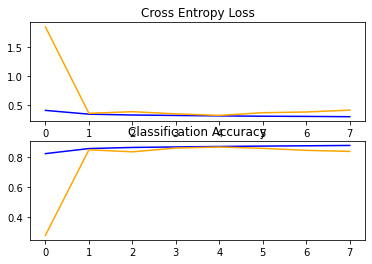

In [50]:
# run the test harness for evaluating a model
def run_test_harness():
    train_df = load_dataset(datadir + "/train/")
    valid_df = load_dataset(datadir + "/valid")
#####################################################
# COMMENT THE LINE BELOW TO RUN FOR ALL IMAGES      #
# 20000 images : split as 16000 : 4000 80%:20%      #
# 16000 / TRAIN_BATCH_SIZE will be the no. of steps #
# i.e., 125 steps * 128 (TRAIN_BATCH_SIZE) = 16000  #
#####################################################
#    train_df = train_df [:500]
    print ("TOTAL IMAGES = %d\n" % len(train_df), train_df)
    train_im, valid_im = split_data (train_df)
    print ("TRAIN_IMAGES = %d (x %d)" % (len(train_im), TRAIN_BATCH_SIZE))
    print ("VALID_IMAGES = %d (x %d)" % (len(valid_im), TRAIN_BATCH_SIZE))
    model = define_model()
    model.summary()
    history = model.fit(
            train_im,
            validation_data=valid_im,
            callbacks=[
            tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=3,
                restore_best_weights=True
            ),
            tf.keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                patience=3
            )
            ],
            #steps_per_epoch=len(train_im),
            #batch_size=TRAIN_BATCH_SIZE,
            epochs=NUM_EPOCHS,
            verbose=True,
        )

    # evaluate the model
    scores = model.evaluate(valid_im, steps=len(valid_im), verbose=5)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    # save model and architecture to single file
    modelName=datadir
    model.save(modelName + ".h5")
    print("Saved model " + modelName + " to disk")
	# learning curves
    summarize_diagnostics(history)
    
#datadir='PetsImages'
#class0='cat'
#class1='dog'
datadir='./cancer/PathImages/'
class0='class0'
class1='class1'
args = sys.argv [1:]
if (len (args) == 3):
    print (args)
    datadir=args[0]
    class0=args[1]
    class1=args[2]
sys_info()
run_test_harness()    